In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

## Datasets

In [332]:
root_path = Path("/home/romet/projects/ut/wp4/dataset")
paths = [
    root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
    root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
    root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
    root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
    root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
    root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
    root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
    root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
    root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
    root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
    root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
    root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
    root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
    root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
    root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
    root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
    root_path / "2021-06-10-12-59-59_e2e_ss4",
    root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
    root_path / "2021-06-10-13-51-34_e2e_ss12",
    root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
    root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
    root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
    root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
    root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
    root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
    root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
    root_path / "2021-06-14-11-22-05_e2e_rec_ss14"
]


dataset = NvidiaDataset(paths, camera="front_wide", transform=None)
positions_df = dataset.frames

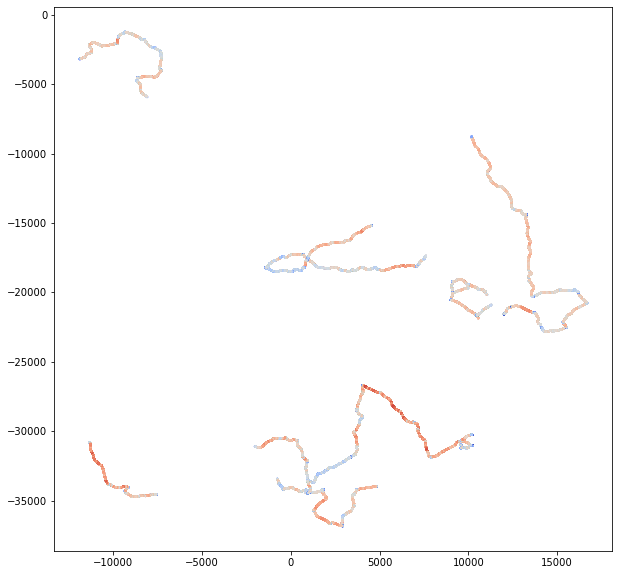

In [186]:
plt.figure(figsize=(10, 10))
plt.scatter(positions_df["position_x"], positions_df["position_y"],
            s=1,
            c=positions_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [334]:
velocity = 30
positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))
positions_df = positions_df[["position_x", "position_y", "position_x2", "position_y2", "yaw", "vehicle_speed", "image_path", "autonomous"]]

In [328]:
positions_df[["position_x", "position_y", "yaw"]]

,position_x,position_y,yaw
1,11299.837048,-20889.408837,-2.435013
2,11299.011255,-20890.127823,-2.431617
3,11298.190688,-20890.845215,-2.428099
4,11297.359741,-20891.574968,-2.424829
5,11296.530407,-20892.304810,-2.420576
...,...,...,...
25888,4359.018758,-15265.119754,0.344028
25889,4359.486114,-15264.947624,0.342777
25890,4359.983977,-15264.764928,0.341489
25891,4360.470848,-15264.586844,0.340110


In [251]:
positions_df.to_parquet('positions.parquet', compression='GZIP')

In [267]:
from sklearn.neighbors import BallTree

positions_df = pd.read_parquet('positions.parquet')
tree = BallTree(positions_df[["position_x", "position_y", "position_x2", "position_y2"]]) 
#tree = BallTree(positions_df[["position_x", "position_y", "yaw"]]) 

In [268]:
positions_df

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed
index,,,,,,
1,11299.837048,-20889.408837,11277.019443,-20908.885923,-2.435013,10.908820
2,11299.011255,-20890.127823,11276.259919,-20909.682278,-2.431617,11.087475
3,11298.190688,-20890.845215,11275.508288,-20910.479590,-2.428099,10.969975
4,11297.359741,-20891.574968,11274.741676,-20911.283421,-2.424829,10.947773
5,11296.530407,-20892.304810,11273.996362,-20912.109274,-2.420576,11.021313
...,...,...,...,...,...,...
25888,4359.018758,-15265.119754,4387.260873,-15255.001308,0.344028,15.285135
25889,4359.486114,-15264.947624,4387.740858,-15254.864498,0.342777,15.263755
25890,4359.983977,-15264.764928,4388.251693,-15254.718225,0.341489,15.219562


In [271]:
import time

def find_speed_for_position(x, y, yaw): 
    x2 = x + (velocity * np.cos(yaw))
    y2 = y + (velocity * np.sin(yaw))
    
    closest = tree.query([[x, y, x2, y2]])
    #closest = tree.query([[x, y, yaw*100]])
    distance = closest[0][0][0]
    index = closest[1][0][0]
    #print(f"distance: {distance:0.5}, index: {index}")
    return positions_df.iloc[index]["vehicle_speed"], distance

In [272]:
speed, distance = find_speed_for_position(11287, -20900, -2.35)
speed

11.36250053167608

Error mean: 0.1065451695957184, max: 7.426775747838926


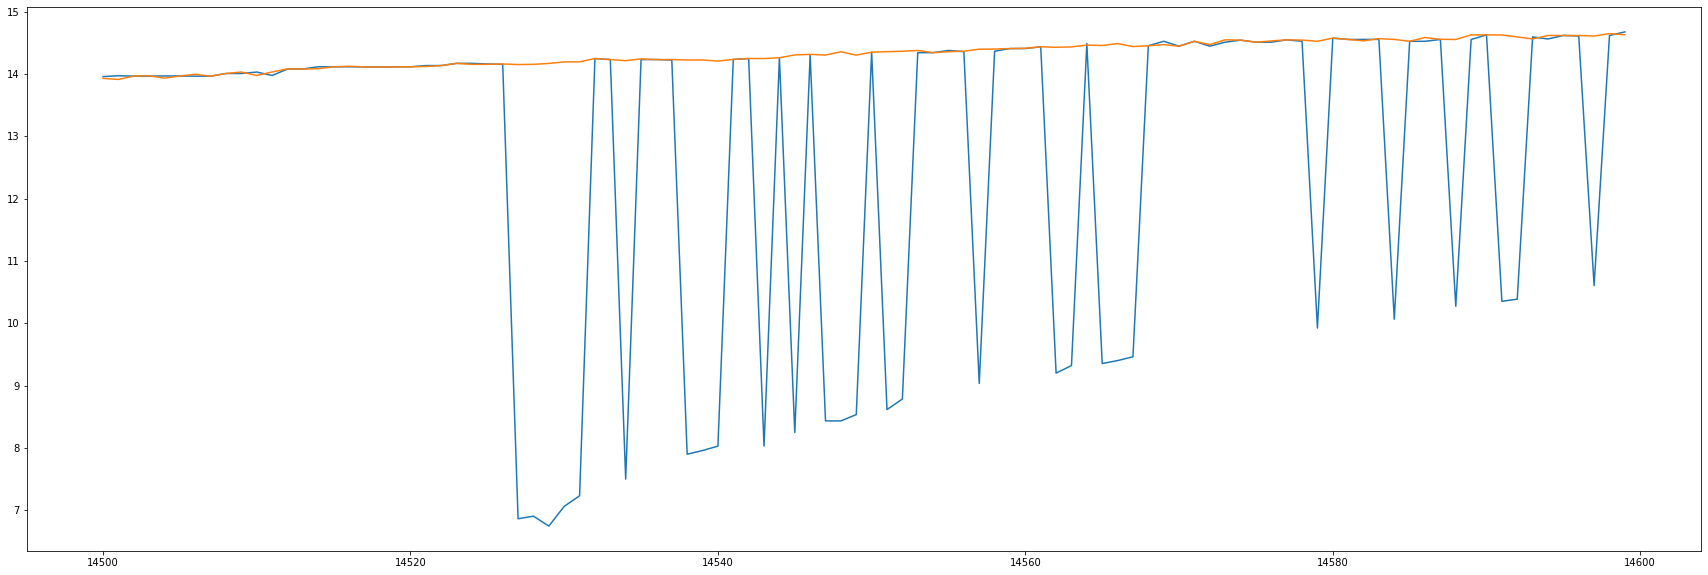

In [307]:
#     root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
#     root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
#     root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
#     root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
#     root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
#     root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
#     root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
#     root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
#     root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
#     root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
#     root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
#     root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
#     root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
#     root_path / "2021-06-10-12-59-59_e2e_ss4",
#     root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
#     root_path / "2021-06-10-13-51-34_e2e_ss12",
#     root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
#     root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
#     root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
#     root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
#     root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
#     root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
#     root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
#     root_path / "2021-06-14-11-22-05_e2e_rec_ss14"

test_df = NvidiaDataset([root_path / "2021-06-10-12-59-59_e2e_ss4"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.05, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"][14500:14600])
plt.plot(test_df["vehicle_speed"][14500:14600])

Error mean: 0.32250578280305353, max: 10.542352928411331


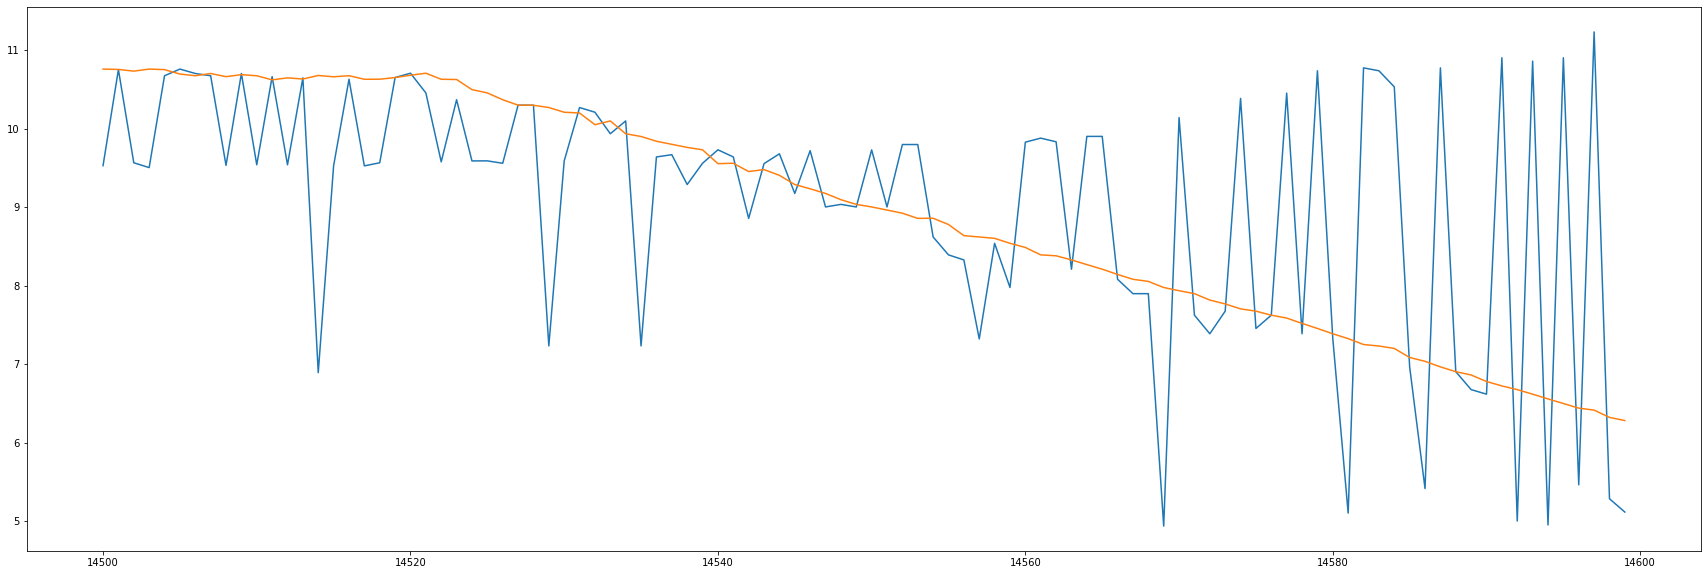

In [300]:
test_df = NvidiaDataset([root_path / "2021-06-10-13-19-22_e2e_ss4_backwards"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.3, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
result_df = result_df[::-1].reset_index()
test_df = test_df[::-1].reset_index()
plt.plot(result_df["vehicle_speed"][14500:14600])
plt.plot(test_df["vehicle_speed"][14500:14600])

In [308]:
test_df[["position_x", "position_y", "yaw"]].iloc[14500:14520]

,position_x,position_y,yaw
14500,945.565460,-33587.058436,-1.335118
14501,945.677752,-33587.511422,-1.333998
14502,945.790997,-33587.965249,-1.332854
14503,945.905642,-33588.422512,-1.331677
14504,946.019483,-33588.875392,-1.330385
14505,946.135235,-33589.333363,-1.329351
14506,946.251556,-33589.792941,-1.328279
14507,946.365064,-33590.241016,-1.327315
14508,946.478930,-33590.690478,-1.326416
14509,946.598179,-33591.158266,-1.325167


In [310]:
result_df.iloc[14540:14560]

,x,y,yaw,vehicle_speed,error
14540,951.006577,-33606.118945,-1.181174,8.028455,6.180402
14541,951.578018,-33605.785523,-1.368271,14.235571,0.000000
14542,951.073185,-33606.479986,-1.345099,14.250000,0.000000
14543,951.185168,-33605.883180,-1.292721,8.028455,6.221545
14544,950.893136,-33607.520289,-1.322162,14.262793,0.000000
14545,951.453964,-33607.270451,-1.283586,8.246448,6.061470
14546,951.741826,-33608.550439,-1.284418,14.306008,0.010331
14547,951.600958,-33608.872427,-1.226227,8.433200,5.872809
14548,951.555092,-33608.723560,-1.224847,8.433200,5.925050
14549,951.434366,-33609.405929,-1.242573,8.534185,5.770604


In [315]:
def find_speed_for_position(x, y, yaw): 
    x2 = x + (velocity * np.cos(yaw))
    y2 = y + (velocity * np.sin(yaw))
    
    closest = tree.query([[x, y, x2, y2]])
    #closest = tree.query([[x, y, yaw*100]])
    distance = closest[0][0][0]
    index = closest[1][0][0]
    print(f"distance: {distance:0.5}, index: {index}")
    return positions_df.iloc[index], distance

In [316]:
find_speed_for_position(951.006577, -33606.118945, -1.181174)

distance: 2.876, index: 257220


(position_x         950.841041
 position_y      -33606.076830
 position_x2        959.668432
 position_y2     -33634.748718
 yaw                 -1.272129
 vehicle_speed        8.028455
 Name: 10695, dtype: float64,
 2.876008370325324)

In [317]:
find_speed_for_position(951.578018, -33605.785523, -1.368271)

distance: 1.787, index: 329602


(position_x         950.583749
 position_y      -33605.892960
 position_x2        959.010850
 position_y2     -33634.685042
 yaw                 -1.286061
 vehicle_speed       14.235571
 Name: 14541, dtype: float64,
 1.7870278504780226)

In [341]:
pd.set_option('display.max_colwidth', None)
positions_df.iloc[[257220]]

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed,image_path,autonomous
10695,950.841041,-33606.07683,959.668432,-33634.748718,-1.272129,8.028455,/home/romet/projects/ut/wp4/dataset/2021-06-09-16-24-59_e2e_rec_ss13/front_wide/1623245457385998964.jpg,False


In [342]:
positions_df.iloc[[329602]]

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed,image_path,autonomous
14541,950.583749,-33605.89296,959.01085,-33634.685042,-1.286061,14.235571,/home/romet/projects/ut/wp4/dataset/2021-06-10-12-59-59_e2e_ss4/front_wide/1623319685118539810.jpg,False


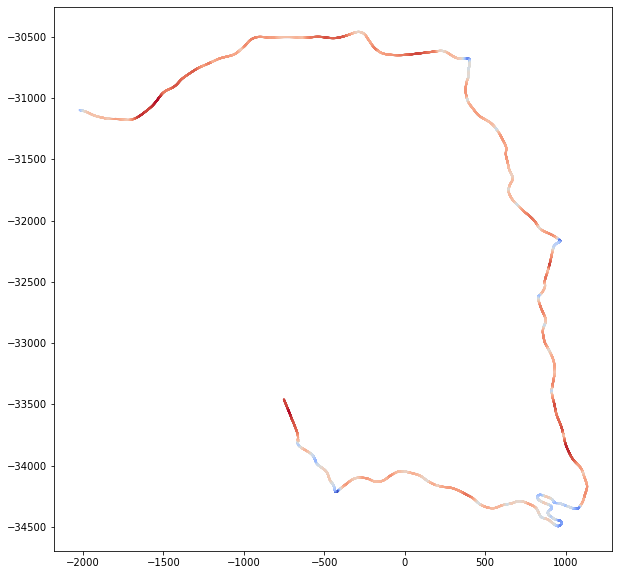

In [352]:
paths = [
    root_path / "2021-06-10-12-59-59_e2e_ss4"
]

foobar_df = NvidiaDataset(paths, camera="front_wide", transform=None).frames
plt.figure(figsize=(10, 10))
plt.scatter(foobar_df["position_x"], foobar_df["position_y"],
            s=1,
            c=foobar_df["vehicle_speed"], cmap=plt.cm.coolwarm);

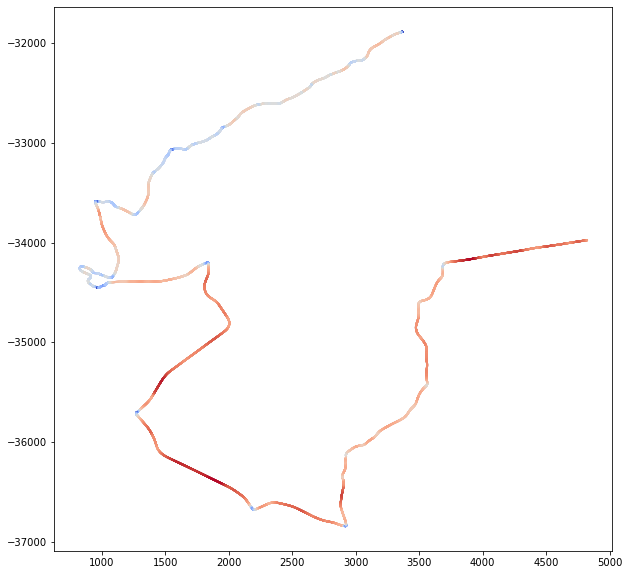

In [353]:
paths = [
    root_path / "2021-06-09-16-24-59_e2e_rec_ss13"
]

foobar_df = NvidiaDataset(paths, camera="front_wide", transform=None).frames
plt.figure(figsize=(10, 10))
plt.scatter(foobar_df["position_x"], foobar_df["position_y"],
            s=1,
            c=foobar_df["vehicle_speed"], cmap=plt.cm.coolwarm);